#  Прогнозирование заказов такси

Компания-агрегатор собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Задача - построить модель для такого предсказания.  
Целевая метка - RMSE, целевое значение на тестовой выборке должно быть не больше 48.

Данные лежат в файле taxi.csv.  
Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

## Подготовка

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time as time

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Прочитаем файл и сразу же сделаем признак даты и время индексом и приведем даты\время в нужный формат.**

**Далее отсортируем данные в хронологическом порядке.**

**После чего сделаем ресемплирование данных по 1 часу.**

**И посмотрим верхние и последние значения в данных, а именно их дату и время.**

In [ ]:
data = pd.read_csv('/content/drive/My Drive/projects/taxi_orders_time_series_forecasting/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()
display(data.head())
data.tail()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


**Наблюдения начинаются 1 марта 2018 в 00:00:00, а заканчиваются 31 августа в 23:00:00.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


**Построим график по ресемплированным данным.**

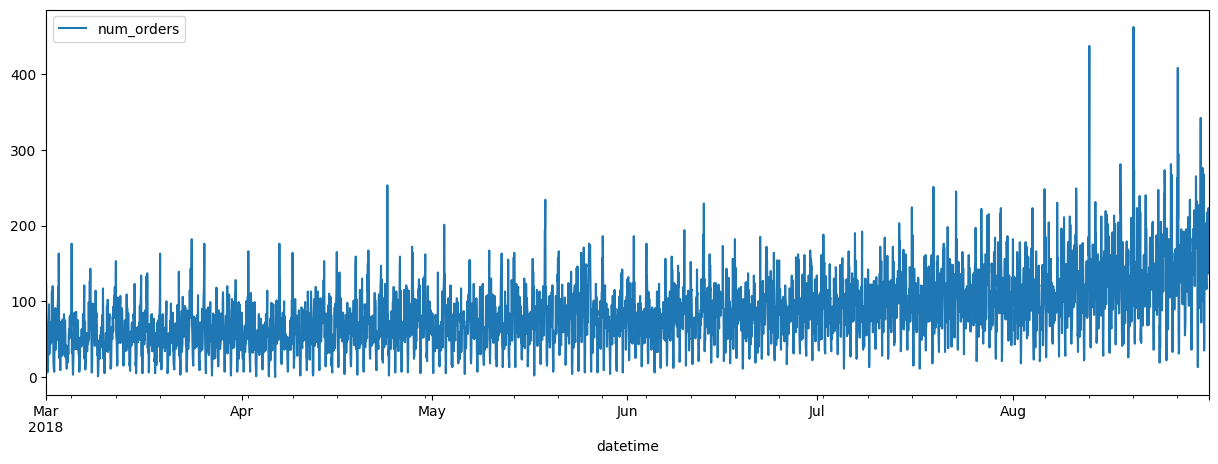

In [ ]:
plt.rcParams["figure.figsize"] = (15, 5) #задаем размер графиков для всех последующих графиков
data.plot();

## Анализ

### Декомпозиция

**Данные не очень подходят для чтения и изучения в исходном виде.**

**Самая ранняя дата в наших данных - это 1 марта 2018, день недели - четверг(в интернете удалось найти данную информацию). Также в интернете удалось найти информацию, что 8 и 9 марта в 2018 году были выходные дни. Поэтому для объективности возьмем для анализа данные за неделю, где не было национальных праздников: 26 марта 2018 - 1 апреля 2018.**

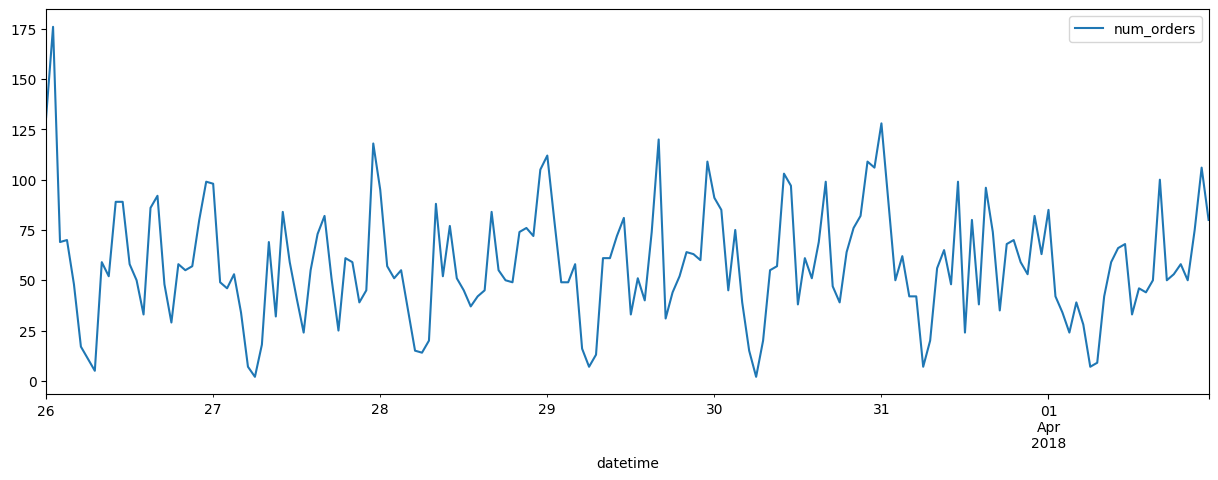

In [ ]:
data['2018-03-26':'2018-04-01'].plot();

**Цикличность данных в течение недели и в течение дня видна, но не максимально очевидна.**

**Для лучшей аналитики декомпозируем исходные данные, т.е. разложим исходный временной ряд на три составляющие: тренд, сезонность и остаток. Остаток - компонента, которая не объясняется трендом и сезонностью, это шум.**

**Посмотрим общий тренд за весь период, сгладив линию с помощью скользящего среднего по 720 часам (24ч*30д).**

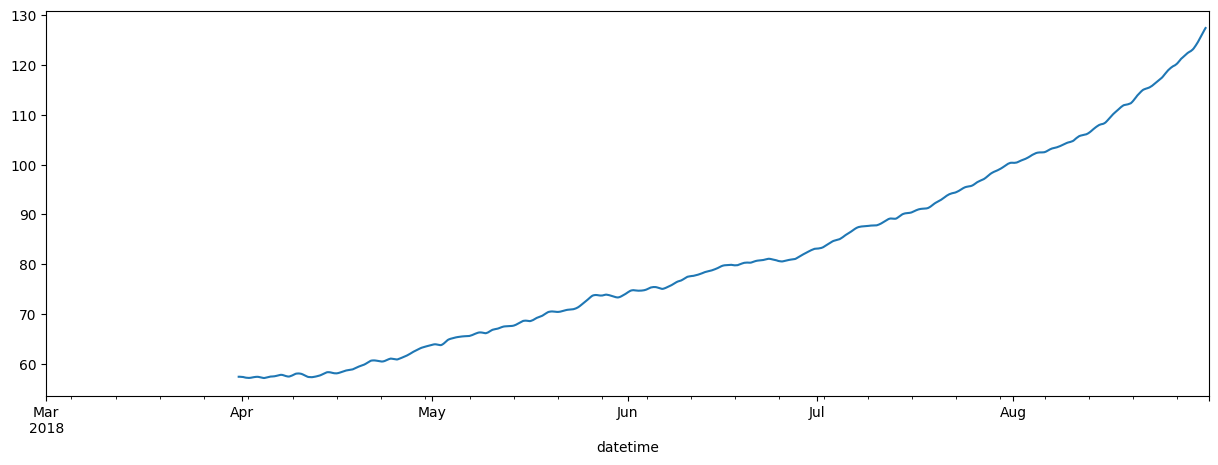

In [ ]:
decomposed = seasonal_decompose(data)
decomposed.trend.rolling(720).mean().plot();

**Видно, что от месяца к месяцу в среднем наблюдается стабильный рост заказов.**

**Посмотрим теперь на циклическую составляющую.**

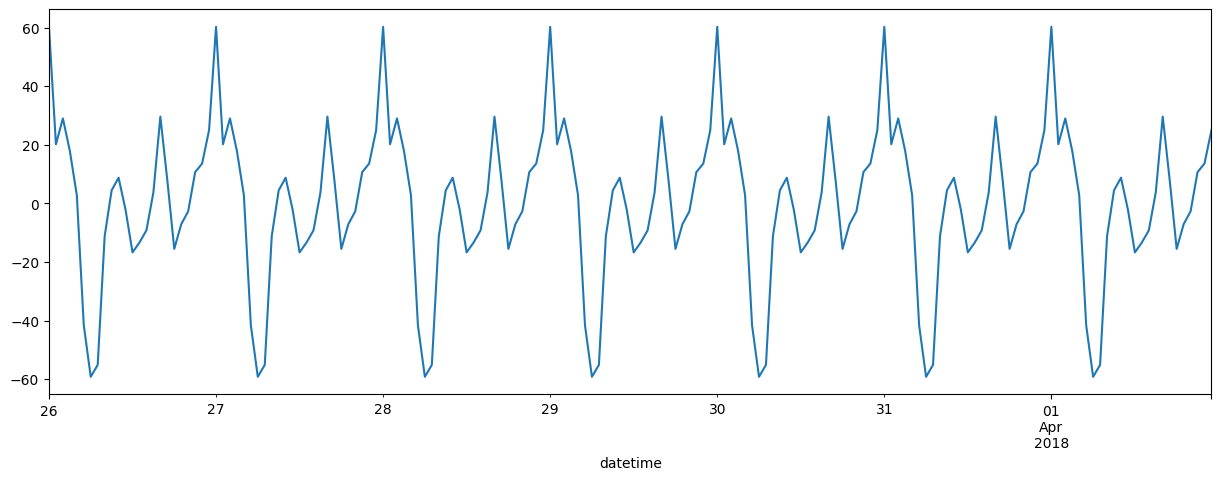

In [ ]:
decomposed.seasonal['2018-03-26':'2018-04-01'].plot(); # циклическая составляющая

**Видим характерный повторяющийся паттерн от дня к дню. Соотвественно, цикличность присутствует на часовом уровне каждых суток и ярко выражен суточный паттерн.**

**Посмотрим чуть подробнее суточных паттерн.**

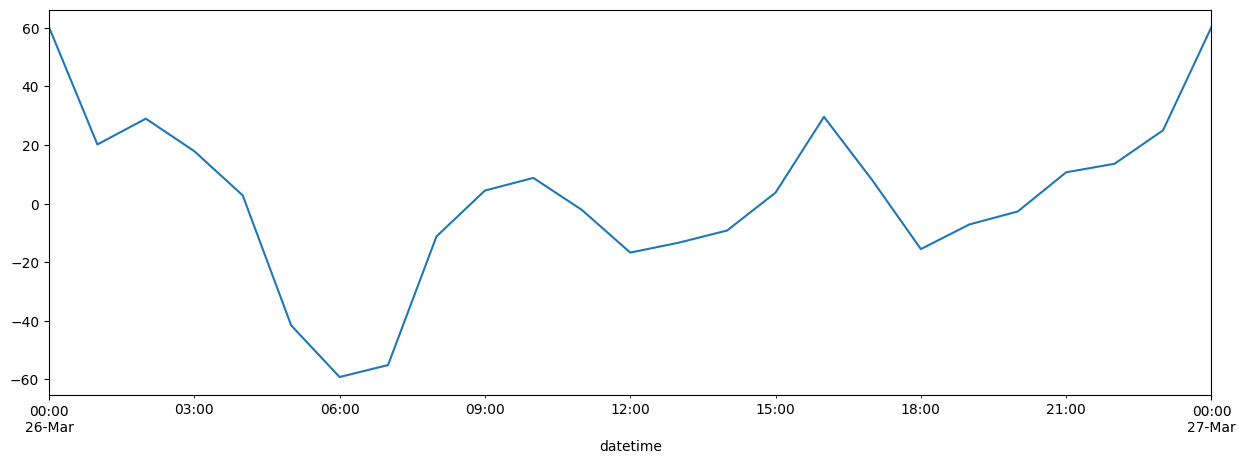

In [ ]:
decomposed.seasonal['2018-03-26 00:00:00':'2018-03-27 00:00:00'].plot();

**В течение суток хорошо видна цикличность - с ночи к 6 утра заказы резко падают до минимума, после снова начинают расти до момента начала рабочего дня, далее небольшой спад до 12 часов, после чего идет рост заказов до 16 часов, снова небольшой спад до 18 часов, после чего наступает конец рабочего дня и идет рост заказов вплоть до ночи. Далее все повторяется. Т.е. просматривается тенденция коррелирующая со стандартным рабочим днем.**

**Посмотрим, есть ли цикличность недельная. Для этого будем декомпозировать данные ресемплированные по 1 дню, посмотрим цикличность за 4 недели, в которые не было национальных праздников.**

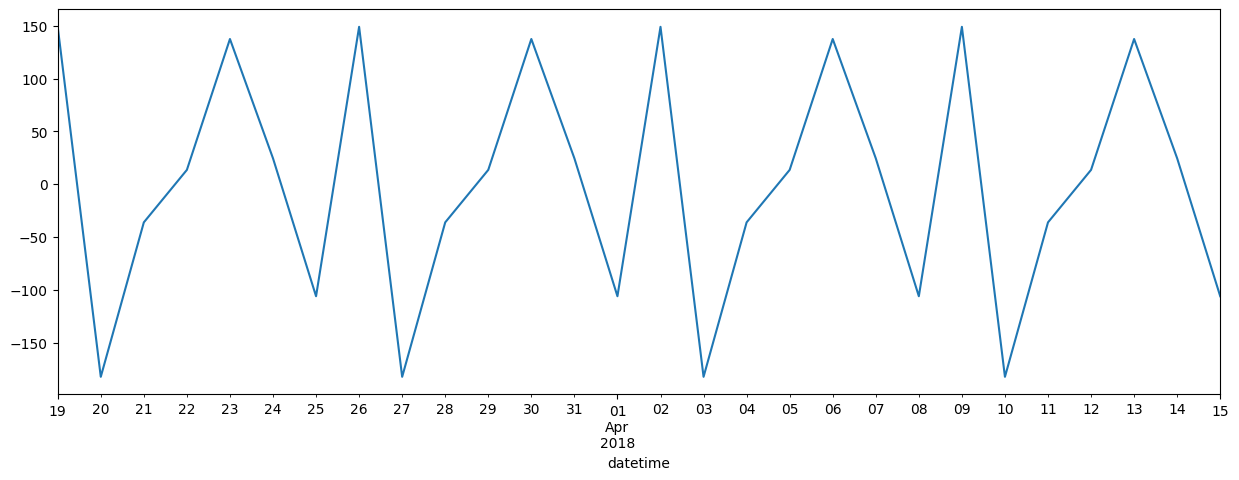

In [ ]:
seasonal_decompose(data.resample('1D').sum()).seasonal['2018-03-19':'2018-04-15'].plot();

**Видим, что наблюдается характерная цикличность по заказам в течение недели:**

**Пик в (ночь воскресенья - понедельник);**

**Далее спад от пика (ночь воскресенья - понедельник) до минимума (ночь понедельника - вторник);**

**Далее плавный рост от минимума (ночь понедельника - вторник) до пика (ночь четверг - пятница), с изменением (уменьшением) роста в течение суток среды;**

**С пика (ночь четверг - пятница) спад до второго по значению минимума (ночь субботы - воскресенье);**

**Далее рост от второго по значению минимума (ночь субботы - воскресенье) до пика (воскресенье ночь - понедельник).**

### Создание дополнительных признаков

**Для прогнозирования необходимо создать дополнительные признаки:**

**- Календарные признаки (месяц, число, день недели, час);**

**- «Отстающие значения» (отставание на различное кол-во часов);**

**- Скользящее среднее (вычисление скользящего среднего не должно включать в себя текущее значение ряда, чтобы целевой признак не «убежал» в признаки);**

**Напишем функцию, которая создает дополнительные признаки.**


In [ ]:
def make_features(data, lags_list, rolling_mean_size): #max_lag - макс. размер отставания
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in lags_list:
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size, closed='left').mean()

make_features(data, [1,2,3,23,24,25], 24) #rolling_mean_size = 24, т.к. это имеем дело с числом заказов такси
data = data.dropna() #удалим пропуски, которые получаются в следствие создания лагов (пред. период недоступен)
data.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,71.0,85.0,124.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,66.0,71.0,85.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,43.0,66.0,71.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,6.0,43.0,66.0,56.958333
2018-03-02 05:00:00,11,3,2,4,5,20.0,64.0,75.0,12.0,6.0,43.0,56.000000


In [ ]:
print('hour_min_value = ', data['hour'].min())
print('hour_max_value = ', data['hour'].max())

hour_min_value =  0
hour_max_value =  23


In [ ]:
print('day_min_value = ', data['day'].min())
print('day_max_value = ', data['day'].max())

day_min_value =  1
day_max_value =  31


In [ ]:
print('dayofweek_min_value = ', data['dayofweek'].min())
print('dayofweek_max_value = ', data['dayofweek'].max())

dayofweek_min_value =  0
dayofweek_max_value =  6


In [ ]:
print('month_min_value = ', data['month'].min())
print('month_max_value = ', data['month'].max())

month_min_value =  3
month_max_value =  8


## Обучение

### Разделение данных на выборки

**Разобъем наш исходный датасет на выборки - тренировочную и тестовую. Отдельную валидационную выборку создавать не будем, т.к. далее воспользуемся GridSearchCV с кросс-валидацией. Т.к. мы имеем дело с временными рядами, разбиение на выборки будем производить без перемешивания данных. А в GridSearchCV будем производить разделение на фолды с помощью TimeSeriesSplit.**

**Будем использовать две модели - регрессия решающим деревом и LightGBM с различными гиперпараметрами.**

**Т.к. в наших данных есть категориальные признаки, то для дальнейшей работы простых моделей с ними, необходимо их закодировать. Воспользуемся циклической кодировкой через sin и cos, найденной на просторах интернета. Т.к. день, час, месяц и число циклически меняются. Для LightGBM отдельным образом признаки кодировать не нужно.**

In [ ]:
#напишем функцию, которая будет кодировать циклические признаки
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#кодируем признак, отвечающий за месяц
data = encode(data, 'month', 12)

#кодируем признак, отвечающий за число
data = encode(data, 'day', 31)

#кодируем признак, отвечающий за день недели
data = encode(data, 'dayofweek', 7)

#кодируем признак, отвечающий за час
data = encode(data, 'hour', 24)

#делим исходный датасет на признаки и целевой признак
target = data['num_orders']
features = data.drop(['num_orders', 'month', 'day', 'dayofweek', 'hour'], axis=1)

display(features.info())
target.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4391 entries, 2018-03-02 01:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lag_1          4391 non-null   float64
 1   lag_2          4391 non-null   float64
 2   lag_3          4391 non-null   float64
 3   lag_23         4391 non-null   float64
 4   lag_24         4391 non-null   float64
 5   lag_25         4391 non-null   float64
 6   rolling_mean   4391 non-null   float64
 7   month_sin      4391 non-null   float64
 8   month_cos      4391 non-null   float64
 9   day_sin        4391 non-null   float64
 10  day_cos        4391 non-null   float64
 11  dayofweek_sin  4391 non-null   float64
 12  dayofweek_cos  4391 non-null   float64
 13  hour_sin       4391 non-null   float64
 14  hour_cos       4391 non-null   float64
dtypes: float64(15)
memory usage: 548.9 KB


<ipython-input-15-b3dee7de507f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
<ipython-input-15-b3dee7de507f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
<ipython-input-15-b3dee7de507f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

None

(4391,)

In [ ]:
#разбиваем признаки и целевые признаки на тренировочную и тестовую выборки в соотношении 90/10
features_train, features_test, target_train, target_test = train_test_split(
    features, target, shuffle=False, test_size=0.1, random_state=1)

#после кодирования все признаки - числовые, поэтому никакие доп. действия не нужно производить с выборками
#чтобы "скормить" их моделям с деревьями и град. бустингом.

#сплит для временных рядов для использования в GridSearchCV
tcv = TimeSeriesSplit(n_splits=5)

print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3951, 15)
(440, 15)
(3951,)
(440,)


In [ ]:
model_tree = DecisionTreeRegressor(random_state=1)

param_tree = {'max_depth':range(1,10,2),
              'criterion':['friedman_mse'],
              'min_samples_split':range(2,10,2),
              'max_depth': range(1,10,2)}
gridsearch_tree = GridSearchCV(
    estimator=model_tree,
    param_grid=param_tree,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_tree.fit(features_train, target_train)
#метрика в gridsearchCV - отрицательное значение RMSE, чтобы получить RMSE необходимо умножить на -1

tree_rmse_train = round((-1 * gridsearch_tree.best_score_), 3)
tree_fit_time_train = round(
    pd.DataFrame(gridsearch_tree.cv_results_).iloc[gridsearch_tree.best_index_]['mean_fit_time'], 3)
print('Лучшее значение метрики RMSE для модели DecTreeReg на тренировочной выборке =', tree_rmse_train)
print('Время обучения модели DecTreeReg с лучшим score на тренировочной выборке =', tree_fit_time_train)
print('Параметры модели DecTreeReg с лучшим score на тренировочной выборке =', gridsearch_tree.best_params_)

Лучшее значение метрики RMSE для модели DecTreeReg на тренировочной выборке = 28.445
Время обучения модели DecTreeReg с лучшим score на тренировочной выборке = 0.013
Параметры модели DecTreeReg с лучшим score на тренировочной выборке = {'criterion': 'friedman_mse', 'max_depth': 5, 'min_samples_split': 4}


In [ ]:
model_lgb = lgb.LGBMRegressor(random_state=1)

param_lgb = {'learning_rate': [0.1, 0.05, 0.01],
             'n_estimators': [50, 100, 200]}
gridsearch_lgb = GridSearchCV(
    estimator=model_lgb,
    param_grid=param_lgb,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_lgb.fit(features_train, target_train)
#метрика в gridsearchCV - отрицательное значение RMSE, чтобы получить RMSE необходимо умножить на -1

lgb_rmse_train = round(-1 * gridsearch_lgb.best_score_, 3)
lgb_fit_time_train = round(
    pd.DataFrame(gridsearch_lgb.cv_results_).iloc[gridsearch_lgb.best_index_]['mean_fit_time'], 3)
print('Лучшее значение метрики RMSE для модели LGBM на тренировочной выборке =', lgb_rmse_train)
print('Время обучения модели LGBM с лучшим score на тренировочной выборке =', lgb_fit_time_train)
print('Параметры модели LGBM с лучшим score на тренировочной выборке =', gridsearch_lgb.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 3951, number of used features: 15
[LightGBM] [Info] Start training from score 78.448494
Лучшее значение метрики RMSE для модели LGBM на тренировочной выборке = 24.694
Время обучения модели LGBM с лучшим score на тренировочной выборке = 0.151
Параметры модели LGBM с лучшим score на тренировочной выборке = {'learning_rate': 0.05, 'n_estimators': 100}


## Тестирование

**Лучшее значение метрики RMSE получено на модели LGBM, лучшее время обучения показала модель регрессии решающего дерева.**

**Проверим теперь лучшую по score модель LGBM на тестовой выборке.**

In [ ]:
start_predict_lgb = time.time()
predict_lgb = gridsearch_lgb.best_estimator_.predict(features_test)
end_predict_lgb = time.time()
print('RMSE для LGBM на тестовой выборке =',
          round(mean_squared_error(target_test, predict_lgb, squared=False),3))
print('Время предсказания LGBM на тестовой выборке =',
          round(end_predict_lgb - start_predict_lgb, 3))

RMSE для LGBM на тестовой выборке = 41.903
Время предсказания LGBM на тестовой выборке = 0.009


## Проверка моделей на адекватность

**Проверим выбранные модели на адекватность с помощью Dummy Model из класса sklearn, предварительно импортировав ее в первом пункте.**

**Проверка состоит в том, чтобы качество выбранной выше обученной модели было выше, чем качество модели Dummy, которая предсказывает результат не опираясь на признаки тренировочной выборки.**

In [ ]:
model_dummy = DummyRegressor()
parameters_dummy = {'strategy':['mean', 'median', 'constant'],
                            'constant':(0,300,10)}
gridsearch_dummy = GridSearchCV(
    estimator=model_dummy,
    param_grid=parameters_dummy,
    scoring='neg_root_mean_squared_error',
    cv=tcv,
    n_jobs=-1)
gridsearch_dummy.fit(features_train, target_train)
print('Лучшее значение метрики RMSE для Dummy-модели на тренировочной выборке =',
      round((-1 * gridsearch_dummy.best_score_), 3))

Лучшее значение метрики RMSE для Dummy-модели на тренировочной выборке = 40.54


In [ ]:
predict_dummy = gridsearch_dummy.best_estimator_.predict(features_test)
print('Лучшее значение метрики RMSE для Dummy-модели на тестовой выборке =',
      round(mean_squared_error(target_test, predict_dummy, squared=False), 3))

Лучшее значение метрики RMSE для Dummy-модели на тестовой выборке = 84.69


**ВЫВОД**

**В итоге с помощью Dummy модели удалось получить наилучшее качество модели с RMSE=84.69 на тестовой выборке, что значительно ниже наилучшего результата выбранных и обученных моделей регрессии решающего дерева и LightGBM. Что доказывает адекватность найденной и выбранной нами модели.**

## Вывод

**Рассмотрели промежуток временного ряда с марта по август 2018, с информацией о количестве произведенных заказов такси. Обнаружили в данных закономерности, связанные с цикличностью. Проверили несколько моделей в задаче прогнозирования количества заказов такси на следующий час.**

**Лучше всего (метрика RMSE) в данной задаче из двух выбранных нами моделей (регрессия решающего дерева и градиентный бустинг LGBM) себя показала вторая модель - LGBM. Получили с помощью модели LightGBM на тестовой выборке значение RMSE=41.903, удовлетворяющее исходной задаче, в которой была сформулирована необходимость получения значения метрики RMSE ниже 48.**